# Predicting customer spend

Thomas Wood

fastdatascience.com

Data science consulting

The dataset I used is from Kaggle, https://www.kaggle.com/c/customer-spend-model

The YouTube video tutorial is at https://www.youtube.com/channel/UCLPrDH7SoRT55F6i50xMg5g

In [2]:
%matplotlib inline
from sqlalchemy import create_engine
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

sqlEngine = create_engine('mysql+pymysql://thomas:@127.0.0.1', pool_recycle=3600)
dbConnection = sqlEngine.connect()
dbConnection.execute("use purchases;")

In [3]:
pd.read_sql_query("SELECT id, orddate, ordnum, category, price FROM orders LIMIT 10", dbConnection)

,id,orddate,ordnum,category,price
0,957,2008-02-10,38650,35,5.010658
1,957,2008-02-10,38650,35,20.426102
2,957,2008-02-10,38650,19,20.400543
3,957,2008-03-15,48972,40,25.539017
4,957,2008-11-22,150011,40,14.316170
5,957,2008-11-22,150011,40,8.589699
6,957,2009-10-03,286151,19,15.313187
7,957,2010-04-04,376779,14,12.782295
8,957,2010-04-04,376779,14,5.087353
9,957,2010-04-04,376779,35,6.544533


In [4]:
dbConnection.execute("""CREATE OR REPLACE VIEW customerDailySpend AS SELECT id, 
       orddate, 
       Sum(price) AS dailySpend
       FROM orders
       GROUP BY id, orddate
       ORDER BY id, orddate;
""")

In [5]:
pd.read_sql_query("""SELECT * FROM customerDailySpend;""", dbConnection)

,id,orddate,dailySpend
0,957,2008-02-10,45.837303
1,957,2008-03-15,25.539017
2,957,2008-11-22,22.905869
3,957,2009-10-03,15.313187
4,957,2010-04-04,24.414181
5,957,2011-08-14,34.103157
6,957,2011-09-10,35.795532
7,957,2011-10-10,45.786179
8,957,2012-06-19,27.900585
9,957,2012-07-28,12.949997


In [6]:
df_features_and_spends = pd.read_sql_query("""SELECT id, 
       orddate, 
       DAYOFWEEK(orddate) as weekday,
       Sum(dailySpend) 
         OVER ( 
           partition BY id 
           ORDER BY id, orddate rows BETWEEN UNBOUNDED PRECEDING AND 1 PRECEDING) as TotalPrecedingSpend,
    Avg(dailySpend) 
         OVER ( 
           partition BY id 
           ORDER BY id, orddate rows BETWEEN UNBOUNDED PRECEDING AND 1 PRECEDING) as AvgPrecedingSpend,
    Sum(dailySpend) 
         OVER ( 
           partition BY id 
           ORDER BY id, orddate rows BETWEEN 1 PRECEDING AND 1 PRECEDING) as PreviousSpend,
    Count(dailySpend) 
         OVER ( 
           partition BY id 
           ORDER BY id, orddate rows BETWEEN UNBOUNDED PRECEDING AND 1 PRECEDING) as NumPrecedingVisits,
    dailySpend
FROM   customerDailySpend 
GROUP  BY id, orddate
ORDER BY id, orddate """, dbConnection)
df_features_and_spends

,id,orddate,weekday,TotalPrecedingSpend,AvgPrecedingSpend,PreviousSpend,NumPrecedingVisits,dailySpend
0,957,2008-02-10,1,NaN,NaN,NaN,0,45.837303
1,957,2008-03-15,7,45.837303,45.837303,45.837303,1,25.539017
2,957,2008-11-22,7,71.376320,35.688160,25.539017,2,22.905869
3,957,2009-10-03,7,94.282188,31.427396,22.905869,3,15.313187
4,957,2010-04-04,1,109.595375,27.398844,15.313187,4,24.414181
5,957,2011-08-14,1,134.009556,26.801911,24.414181,5,34.103157
6,957,2011-09-10,7,168.112713,28.018785,34.103157,6,35.795532
7,957,2011-10-10,2,203.908245,29.129749,35.795532,7,45.786179
8,957,2012-06-19,3,249.694424,31.211803,45.786179,8,27.900585
9,957,2012-07-28,7,277.595009,30.843890,27.900585,9,12.949997


In [7]:
df_features_and_spends.dropna(inplace=True)

C:\Users\woodt.DESKTOP-QB0N6BQ\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


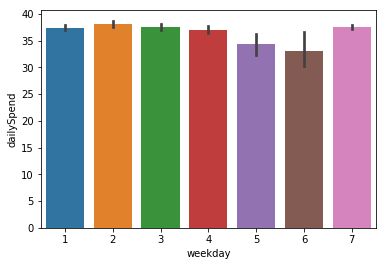

In [8]:
sns.barplot(x="weekday", y="dailySpend", data=df_features_and_spends)

# Start machine learning modelling

In [9]:
m = RandomForestRegressor()

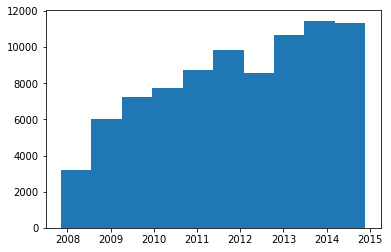

In [10]:
plt.hist(df_features_and_spends.orddate);

In [11]:
df_train = df_features_and_spends[df_features_and_spends.orddate < pd.Timestamp(2014,1,1)]
df_test = df_features_and_spends[df_features_and_spends.orddate >= pd.Timestamp(2014,1,1)]

In [12]:
m.fit(df_train.drop(["id", "orddate", "dailySpend"], axis=1), df_train.dailySpend)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [13]:
y_pred = m.predict(df_test.drop(["id", "orddate", "dailySpend"], axis=1))

In [14]:
y_pred

array([33.51338749, 17.83421974, 80.52126675, ..., 66.88864593,
       10.9049942 , 68.45940743])

In [15]:
df_test["y_pred"] = y_pred

C:\Users\woodt.DESKTOP-QB0N6BQ\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [16]:
df_test

,id,orddate,weekday,TotalPrecedingSpend,AvgPrecedingSpend,PreviousSpend,NumPrecedingVisits,dailySpend,y_pred
12,957,2014-07-19,7,333.244995,27.770416,19.949997,12,22.799994,33.513387
13,957,2014-07-29,3,356.044989,27.388076,22.799994,13,26.799990,17.834220
28,2062,2014-06-02,2,945.168905,67.512065,90.799971,14,89.838577,80.521267
29,2062,2014-07-13,1,1035.007483,69.000499,89.838577,15,43.599985,57.606519
65,2232,2014-02-02,1,1343.310947,38.380313,59.699984,35,9.949997,31.583850
66,2232,2014-03-12,4,1353.260944,37.590582,9.949997,36,3.949999,27.544093
101,4251,2014-10-12,1,607.213722,55.201247,17.949997,11,81.389975,47.400041
103,4642,2014-01-05,1,27.799988,27.799988,27.799988,1,22.899994,25.056789
123,5002,2014-10-19,1,642.402832,33.810675,28.899994,19,33.849997,54.553231
163,6084,2014-02-19,4,1532.841331,39.303624,89.099976,39,36.849991,47.298953


In [17]:
residuals = df_test.y_pred - df_test.dailySpend

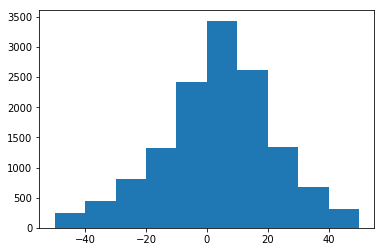

In [18]:
plt.hist(residuals, range=(-50,50));

In [19]:
mean_absolute_error(df_test.dailySpend, df_test.y_pred)

20.50122664872518

# Prediction for the future

In [20]:
df_features_and_spends_for_prediction = pd.read_sql_query("""SELECT id,
    2 as weekday,
       Sum(dailySpend)  as TotalPrecedingSpend,
    Avg(dailySpend) 
         as AvgPrecedingSpend,
        LAST_VALUE(dailySpend) OVER (partition by id order by id, orddate) as PreviousSpend,
    Count(dailySpend)  as NumPrecedingVisits
FROM   customerDailySpend 
GROUP  BY id
ORDER BY id """, dbConnection)
df_features_and_spends_for_prediction

,id,weekday,TotalPrecedingSpend,AvgPrecedingSpend,PreviousSpend,NumPrecedingVisits
0,957,2,382.844978,27.346070,45.837303,14
1,2062,2,1078.607468,67.412967,62.658798,16
2,2232,2,1357.210943,36.681377,86.331577,37
3,2623,2,152.059544,30.411909,44.431252,5
4,3000,2,258.645792,19.895830,22.854744,13
5,3689,2,137.147575,27.429515,20.349411,5
6,4251,2,688.603697,57.383641,25.436768,12
7,4642,2,50.699982,25.349991,27.799988,2
8,5002,2,676.252829,33.812641,43.204155,20
9,6084,2,2235.781071,40.650565,15.287621,55


In [21]:
y_pred_future = m.predict(df_features_and_spends_for_prediction.drop(["id"], axis=1))

In [22]:
df_features_and_spends_for_prediction["y_pred_future"] = y_pred_future

In [23]:
df_features_and_spends_for_prediction

,id,weekday,TotalPrecedingSpend,AvgPrecedingSpend,PreviousSpend,NumPrecedingVisits,y_pred_future
0,957,2,382.844978,27.346070,45.837303,14,22.316426
1,2062,2,1078.607468,67.412967,62.658798,16,41.025150
2,2232,2,1357.210943,36.681377,86.331577,37,40.972302
3,2623,2,152.059544,30.411909,44.431252,5,31.733879
4,3000,2,258.645792,19.895830,22.854744,13,16.064438
5,3689,2,137.147575,27.429515,20.349411,5,29.277434
6,4251,2,688.603697,57.383641,25.436768,12,47.425355
7,4642,2,50.699982,25.349991,27.799988,2,35.318720
8,5002,2,676.252829,33.812641,43.204155,20,37.709102
9,6084,2,2235.781071,40.650565,15.287621,55,53.625515
